In [ ]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

# load data
adata = sc.read("zheng68k_preprocessed.h5ad")
adata.raw = adata
labels = adata.obs["celltype"].astype(str).values

/root/miniconda3/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# StratifiedKFold 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# train（1/5）， test (4/5)
test_idx, train_idx = next(iter(skf.split(adata, labels))) 

# keep train label，set test to Unknown
adata_fold = adata.copy()
adata_fold.obs["seed_labels"] = adata_fold.obs["celltype"].astype(str)
adata_fold.obs.iloc[test_idx, adata_fold.obs.columns.get_loc("seed_labels")] = "Unknown"  # 现在 test 是 Unknown

# SCVI model
scvi.model.SCVI.setup_anndata(adata_fold, labels_key="seed_labels")

# train SCVI
scvi_model = scvi.model.SCVI(adata_fold, n_latent=30)
start_train = time.time()
scvi_model.train(max_epochs=100)
train_time_scvi = time.time() - start_train

# train SCANVI
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, unlabeled_category="Unknown")
start_train_scanvi = time.time()
scanvi_model.train(max_epochs=25)
train_time_scanvi = time.time() - start_train_scanvi

total_train_time = train_time_scvi + train_time_scanvi

# predict
start_predict = time.time()
pred_all = scanvi_model.predict(adata_fold)
predict_time = time.time() - start_predict

# get test result
true_labels = labels[test_idx].tolist()
pred_labels = pred_all[test_idx].tolist()

# save file
import pandas as pd
pd.DataFrame(true_labels).to_csv("scANVI_True_Labels1.csv", index=False)
pd.DataFrame(pred_labels).to_csv("scANVI_Pred_Labels1.csv", index=False)
pd.DataFrame([total_train_time], columns=["Training_Time"]).to_csv("scANVI_Training_Times1.csv", index=False)
pd.DataFrame([predict_time], columns=["Testing_Time"]).to_csv("scANVI_Testing_Times1.csv", index=False)

In [ ]:
adata_fold.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata_fold)
adata_fold.obs["scANVI_pred"] = pred_all

sc.pp.neighbors(adata_fold, use_rep="X_scANVI")
sc.tl.umap(adata_fold)

sc.pl.umap(adata_fold, color=["celltype", "scANVI_pred"], title=["True Labels", "scANVI Predicted"])

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/root/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/root/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


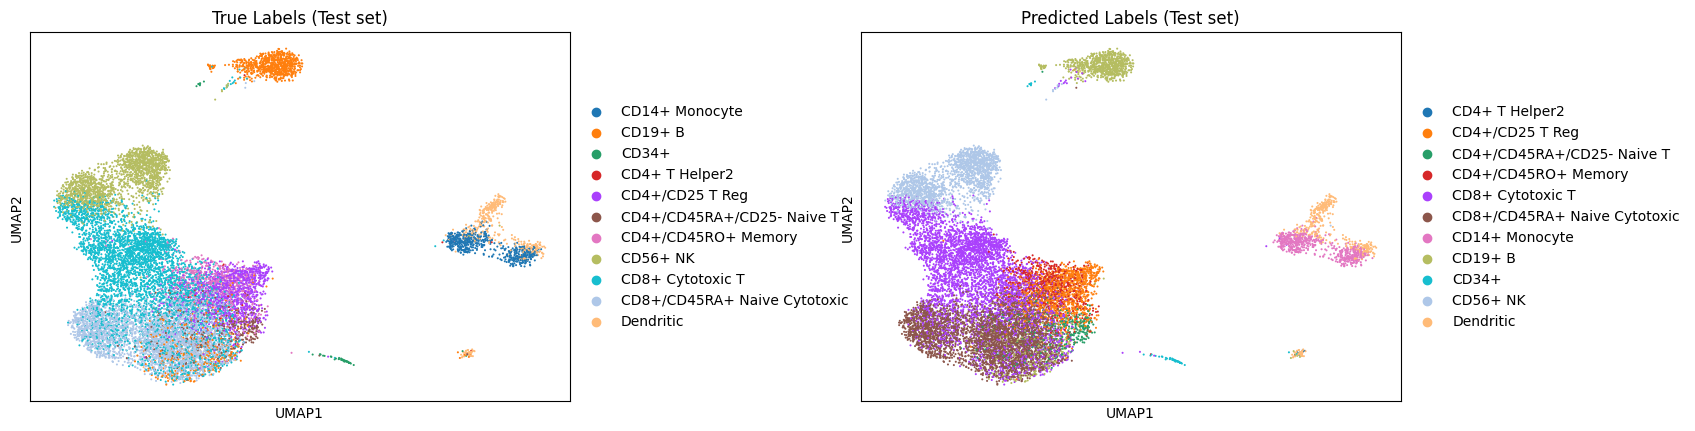

In [ ]:
adata_test = adata_fold[test_idx].copy()

adata_test.obs["scANVI_pred"] = pred_labels

adata_test.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata_test)

sc.pp.neighbors(adata_test, use_rep="X_scANVI")
sc.tl.umap(adata_test)

sc.pl.umap(
    adata_test, 
    color=["celltype", "scANVI_pred"], 
    title=["True Labels (Test set)", "Predicted Labels (Test set)"], 
    wspace=0.4
)